In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from yaml import safe_load, YAMLError
from src.utils import setup_output_folder
from src.snapshots import snapshots_assembly, data_normalization, insert_h5_vector
from src.linear_reduction import SVD
from src.nonlinear_reduction import AutoEncoder
from src.data_split import DataSplitter

In [9]:
with open("parameters.yaml", "r") as stream:
    try:
        params = safe_load(stream)
    except YAMLError as exc:
        print(exc)

In [4]:
params

{'experiment_name': 'loss_5000',
 'random_state': 42,
 'normalization': {'snapshots': None,
  'svd': 'min_max',
  'autoencoder': None,
  'surrogate': None},
 'splitting': {'strategy': 'temporal',
  'number_of_folds_or_splits': 2,
  'train_size': 0.8,
  'validation_size': 300,
  'test_size': 0.1,
  'gap': 0},
 'snapshots': {'file_type_str': 'h5_fenics',
  'folder': 'data/input',
  'visualization_folder': 'data/visualization',
  'file_name_contains': ['concentration'],
  'dataset': None},
 'svd': {'trunc_basis': 27,
  'normalization': 'min_max',
  'svd_type': 'randomized_svd',
  'power_iterations': 1,
  'oversampling': 20},
 'auto_encoder': {'batch_size': 300,
  'num_epochs': 1,
  'learning_rate': '1e-4',
  'weight_decay': '1e-8',
  'loss_function': 'smooth_l1_loss',
  'loss_parameters': {'beta': 0.2},
  'num_workers': 2,
  'number_of_hidden_layers': 5,
  'hidden_layers_sizes': [256, 128, 64, 32, 16],
  'hidden_layers_activation_function': ['leaky_relu',
   'leaky_relu',
   'leaky_relu',

In [10]:
filenames, snapshots = snapshots_assembly(params["snapshots"])
snapshots.shape

2024-01-27 18:19:26,174 - src.snapshots - INFO - Starting choice of file type:
2024-01-27 18:19:26,175 - src.snapshots - INFO - FEniCS HDF5 file selected.
2024-01-27 18:19:26,176 - src.snapshots - INFO - Searching for files that containg the string 'concentration'.
2024-01-27 18:19:26,186 - src.snapshots - INFO - 3000 snapshots found.


Loading Snapshots 2999: 100%|██████████| 2999/2999 [00:12<00:00, 246.90it/s]


(70801, 3000)

In [37]:


def pipeline_modes():
    # setup directories
    output_folder = setup_output_folder(params)

    # high dimensional data
    svd = SVD(snapshots, params, output_folder)
    svd.fit()
    svd.plot_singular_values(save_only=True)
    spatial_modes = svd.u
    print(f"spatial modes dim: {spatial_modes.shape}")

    # train_test split
    data_splitter = DataSplitter(params)
    folded_data = data_splitter.preserve_test_data(spatial_modes)
    train_data = folded_data[0]["train"]
    test_data = folded_data[0]["test"] 

    # preprocess high dimensional data
    normalized_spatial_train_modes, u_normalization_train_obj = data_normalization(
    train_data, params, "svd", transpose=False
    )    
    print(f"normalized spatial train modes dim: {normalized_spatial_train_modes.shape}")

    # fit high dimensional data
    auto_encoder = AutoEncoder(normalized_spatial_train_modes, params, output_folder)
    auto_encoder.fit()
    auto_encoder.plot_quantities_per_epoch("avg_loss_by_epoch")

    # compute error for training data
    normalized_train_predictions = auto_encoder.predict(normalized_spatial_train_modes)
    train_predictions = u_normalization_train_obj.inverse_transform(normalized_train_predictions)

    # TODO: Compute L2 norm for train data (train_predictions and train_data)


    # compute error for test data
    normalized_spatial_test_modes, u_normalization_test_obj = data_normalization(
    test_data, params, "svd", transpose=False
    )    
    print(f"normalized spatial test modes dim: {normalized_spatial_train_modes.shape}")
    normalized_test_predictions = auto_encoder.predict(normalized_spatial_test_modes)
    test_predictions = u_normalization_test_obj.inverse_transform(normalized_test_predictions)

    # TODO: Compute L2 norm for train data (train_predictions and train_data)

    


2024-01-27 18:52:05,358 - src.data_split - INFO - -------------------- Starting standard train/test strategy --------------------
2024-01-27 18:52:05,358 - src.data_split - INFO - -------------------- Starting standard train/validation strategy --------------------
2024-01-27 18:52:05,366 - src.data_split - INFO - Number of folds: 1
2024-01-27 18:52:05,367 - src.data_split - INFO - Dimensions of fold 0: (70801, 24)
2024-01-27 18:52:05,368 - src.data_split - INFO - Dimensions of fold 0: (70801, 3)


(70801, 47)
(47, 47)
spatial modes dim: (70801, 27)
normalized spatial train modes dim: (70801, 24)


2024-01-27 18:52:05,707 - src.nonlinear_reduction - INFO - -------------------- Starting training for AutoEncoder --------------------
2024-01-27 18:52:05,708 - src.nonlinear_reduction - INFO -  # of data: torch.Size([24, 70801])
2024-01-27 18:52:05,709 - src.nonlinear_reduction - INFO -  # of layers: 5
2024-01-27 18:52:05,710 - src.nonlinear_reduction - INFO -  Encoder architecture: Sequential(
  (0): Linear(in_features=70801, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Linear(in_features=32, out_features=16, bias=True)
)
/home/gfbarros/anaconda3/envs/turbiditos_surrogate/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will 

<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


normalized spatial test modes dim: (70801, 24)


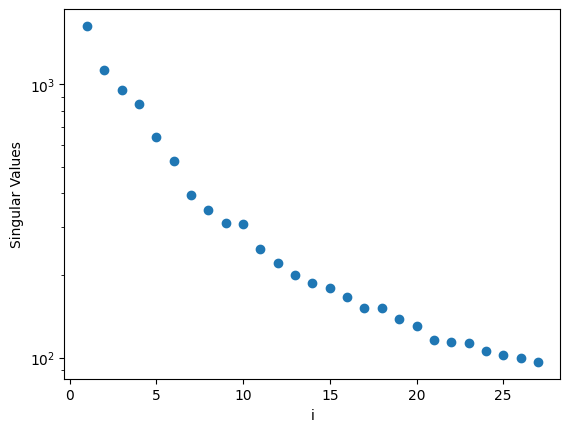

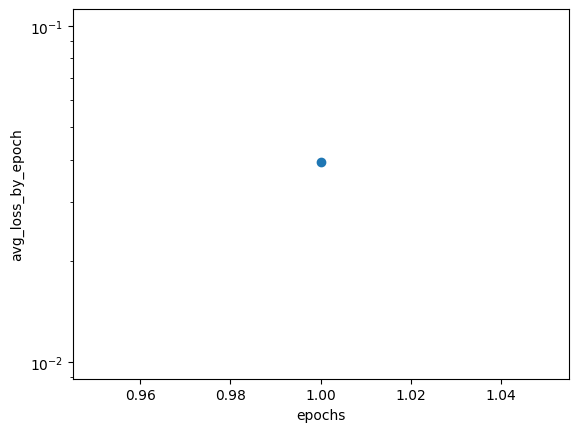

In [38]:
pipeline_modes()

In [ ]:
svd_step_randomized = SVD(snapshots, params["svd"])
svd_step_randomized.fit()
svd_step_randomized.plot_singular_values()

In [ ]:
projected_snapshots = svd_step_randomized.u.T @ snapshots

projected_snapshots_normalized, u_normalization_obj = data_normalization(
    projected_snapshots, params["svd"], transpose=False
)  # min_max vetores singulares a esquerda
projected_snapshots_normalized.shape

In [ ]:
# u_normalized[0, :].max()

In [ ]:
# vector = u_normalized[:, 0]
# insert_h5_vector(
#     vector,
#     params["snapshots"],
# )

In [ ]:
ae_test_2 = AutoEncoder(projected_snapshots_normalized, params["auto_encoder"])
ae_test_2.fit()

# print(ae_test_2.auto_encoder.encoder)
# print(ae_test_2.auto_encoder.decoder)

In [ ]:
ae_test_2.plot_quantities_per_epoch("avg_loss_by_epoch")

In [ ]:
# 1a analise: erro do autoencoder (apenas)

import torch

f_original_autoencoder = projected_snapshots_normalized[:, 0]
f_reconstructed = ae_test_2.auto_encoder.forward(
    torch.tensor(f_original_autoencoder, dtype=torch.float32)
)
print(f_reconstructed.shape)

import numpy as np

np.linalg.norm(
    f_original_autoencoder - f_reconstructed.detach().numpy()
) / np.linalg.norm(f_original_autoencoder, 2)

In [ ]:
# 2a analise: erro do snapshot
f_reconstructed = ae_test_2.auto_encoder.forward(
    torch.tensor(projected_snapshots_normalized.T, dtype=torch.float32)
)
f_reconstructed_numpy = f_reconstructed.detach().numpy().T
projected_snapshots_return = u_normalization_obj.inverse_transform(
    f_reconstructed_numpy
)
print(projected_snapshots_return.shape)
print(svd_step_randomized.u.shape)
snapshots_returned = svd_step_randomized.u @ projected_snapshots_return

import numpy as np

snapshot_number = 2500

np.linalg.norm(
    snapshots[:, snapshot_number] - snapshots_returned[:, snapshot_number]
) / np.linalg.norm(snapshots[:, snapshot_number], 2)

vector = snapshots_returned[:, snapshot_number]
insert_h5_vector(
    vector,
    params["snapshots"],
)

vector = snapshots[:, snapshot_number]
insert_h5_vector(vector, params["snapshots"], vector_dir="original_vector")

In [ ]:
# TODO: train_test_split
# TODO: organizar plots, geração de erros e dados
# TODO: jogar no google docs
# TODO: surrogate